In [1]:
import torch
import numpy
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt 
from targets.Lotka_Volterra import * 

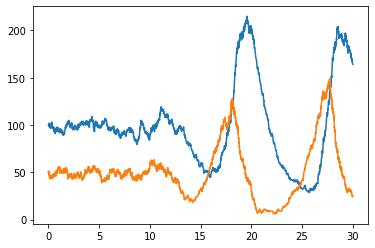

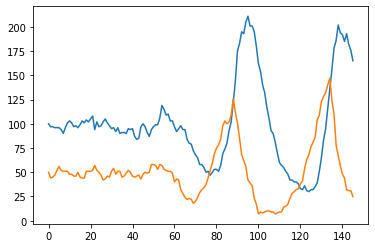

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.02it/s]


In [20]:
n_obs = 100
theta_0 = torch.log(torch.tensor([0.01, 0.5, 1, 0.01]))
_, time, predator, prey = simulate(theta_0, max_time=30,initial_state = [100,50])
plt.plot(time, predator)
plt.plot(time, prey)
plt.show()
plt.plot(sample_signal(time,predator, .2))
plt.plot(sample_signal(time,prey,.2))
plt.show()
x_0 = torch.stack([simulate(theta_0, max_time=30,initial_state = [100,50])[0] for _ in tqdm(range(n_obs))])

In [9]:
n_D = 200
D_theta = []
D_x = []
for t in tqdm(range(n_D)):
    params = torch.distributions.Uniform(-5,2).sample([4]).numpy()
    theta = theta_0 + torch.randn(4)
    x= simulate(theta, max_time=30,initial_state = [100,50], dt = .2)[0]
    if x.isnan().sum() == 0:
        D_x.append(x)
        D_theta.append(theta)
D_theta = torch.stack(D_theta, dim =0)
D_x = torch.stack(D_x, dim =0)

 28%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                        | 55/200 [00:44<01:21,  1.78it/s]c:\users\elouan\pycharmprojects\sbi\venv\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\elouan\pycharmprojects\sbi\venv\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:00<00:00,  1.11it/s]


In [30]:
from conditional_density_estimators import ConditionalDIFDensityEstimator
dif = ConditionalDIFDensityEstimator(D_x.float(),D_theta.float(), 10,[32,32,32])
dif.train(10000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:53<00:00, 88.36it/s, loss = 7.438626 ; device: cuda]


In [31]:
from posterior_sampler import WLBSampler

In [32]:
sampler = WLBSampler(dif.log_density,4,x_0.float())
samples = sampler.sample(200,epochs = 1000, lr = 1e-2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:10<00:00,  5.26it/s, 411.34613037109375]


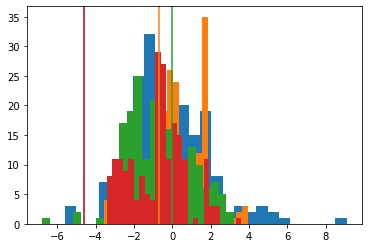

In [37]:
for i in range(4):
    plt.hist(samples[:,i].detach().numpy(), bins =25, color = 'C'+str(i))
    plt.axvline(theta_0[i], c = 'C'+str(i))